## Financial Transaction Reconciliation

### Business Context

**Problem:** Finance teams spend hours each day matching bank transactions with internal ledger records. This is time-consuming, error-prone, and doesn't scale as transaction volumes grow.

**Solution:** Building an automated reconciliation system that:
 1. Matches bank and ledger transactions using realistic rules
 2. Flags discrepancies that need human attention
 3. Produces clear reports for daily operations

**reconciliation process:**

1. **Understanding the Data** – What we're working with
2. **Cleaning & Standardization** – Getting the data match-ready
3. **Feature Engineering** – Creating smart matching features
4. **Reconciliation Logic** – The actual matching rules
5. **Results & Reporting** – Business-ready outputs

### 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from rapidfuzz import fuzz
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Setting up visual style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

**Loading two main datasets**

In [4]:
# Bank statement - the external truth from our bank
bank_df = pd.read_csv("../data/bank_statement.csv")
print(f"Bank statement loaded: {len(bank_df)} transactions")

# Ledger transactions - our internal accounting records
ledger_df = pd.read_csv("../data/ledger_transactions.csv")
print(f"Ledger transactions loaded: {len(ledger_df)} transactions")

# Let's peek at the data
print("\nFirst few bank transactions:")
display(bank_df.head(3))

print("\nFirst few ledger transactions:")
display(ledger_df.head(3))

Bank statement loaded: 500 transactions
Ledger transactions loaded: 500 transactions

First few bank transactions:


,transaction_id,date,amount,reference,description,bank_account,transaction_type
0,BANK00250,2024-01-01,418.23,REF984979,Transaction REF984979,BUSINESS_ACCOUNT_001,CREDIT
1,BANK00105,2024-01-01,799.12,REF242045,Transaction REF242045,BUSINESS_ACCOUNT_001,DEBIT
2,BANK00136,2024-01-01,1068.91,CHK356210,Transaction CHK356210,BUSINESS_ACCOUNT_001,DEBIT



First few ledger transactions:


,transaction_id,date,amount,reference,description,bank_account,transaction_type,gl_account,posted_by
0,LEDG00165,2024-01-01,603.77,INV-476627,Transaction INV476627,BUSINESS_ACCOUNT_001,DEBIT,2002,USER_JOHN
1,LEDG00380,2024-01-01,1068.91,CHK356210,Transaction CHK356210,BUSINESS_ACCOUNT_001,DEBIT,2002,SYSTEM_AUTO
2,LEDG00122,2024-01-01,829.56,SAL558783,Transaction SAL558783,BUSINESS_ACCOUNT_001,CREDIT,1002,SYSTEM_AUTO


### 2. Understanding the Data (Exploratory Analysis)

**Basic information about data**

In [5]:
print("Bank Statement Data")
print(f"Date range: {bank_df['date'].min()} to {bank_df['date'].max()}")
print(f"Amount range: ${bank_df['amount'].min():.2f} to ${bank_df['amount'].max():.2f}")
print(f"Total transactions: {len(bank_df):,}")
print(f"Total amount: ${bank_df['amount'].sum():,.2f}")

print("\nLedger Data (Internal Accounting Records)")
print(f"Date range: {ledger_df['date'].min()} to {ledger_df['date'].max()}")
print(f"Amount range: ${ledger_df['amount'].min():.2f} to ${ledger_df['amount'].max():.2f}")
print(f"Total transactions: {len(ledger_df):,}")
print(f"Total amount: ${ledger_df['amount'].sum():,.2f}")

Bank Statement Data
Date range: 2024-01-01 to 2024-03-30
Amount range: $10.47 to $1999.44
Total transactions: 500
Total amount: $399,291.10

Ledger Data (Internal Accounting Records)
Date range: 2024-01-01 to 2024-03-30
Amount range: $10.47 to $1999.44
Total transactions: 500
Total amount: $399,128.08


**Checking for missing values as these can break reconciliation**

In [7]:
print("\nChecking for missing values:")

missing_bank = bank_df.isnull().sum()
missing_ledger = ledger_df.isnull().sum()

print("Missing values in bank statement:")
print(missing_bank[missing_bank > 0])

print("\nMissing values in ledger:")
print(missing_ledger[missing_ledger > 0])


Checking for missing values:
Missing values in bank statement:
Series([], dtype: int64)

Missing values in ledger:
reference    21
dtype: int64


**Visual of transaction volumes Comparison between Bank and Ledger over time**

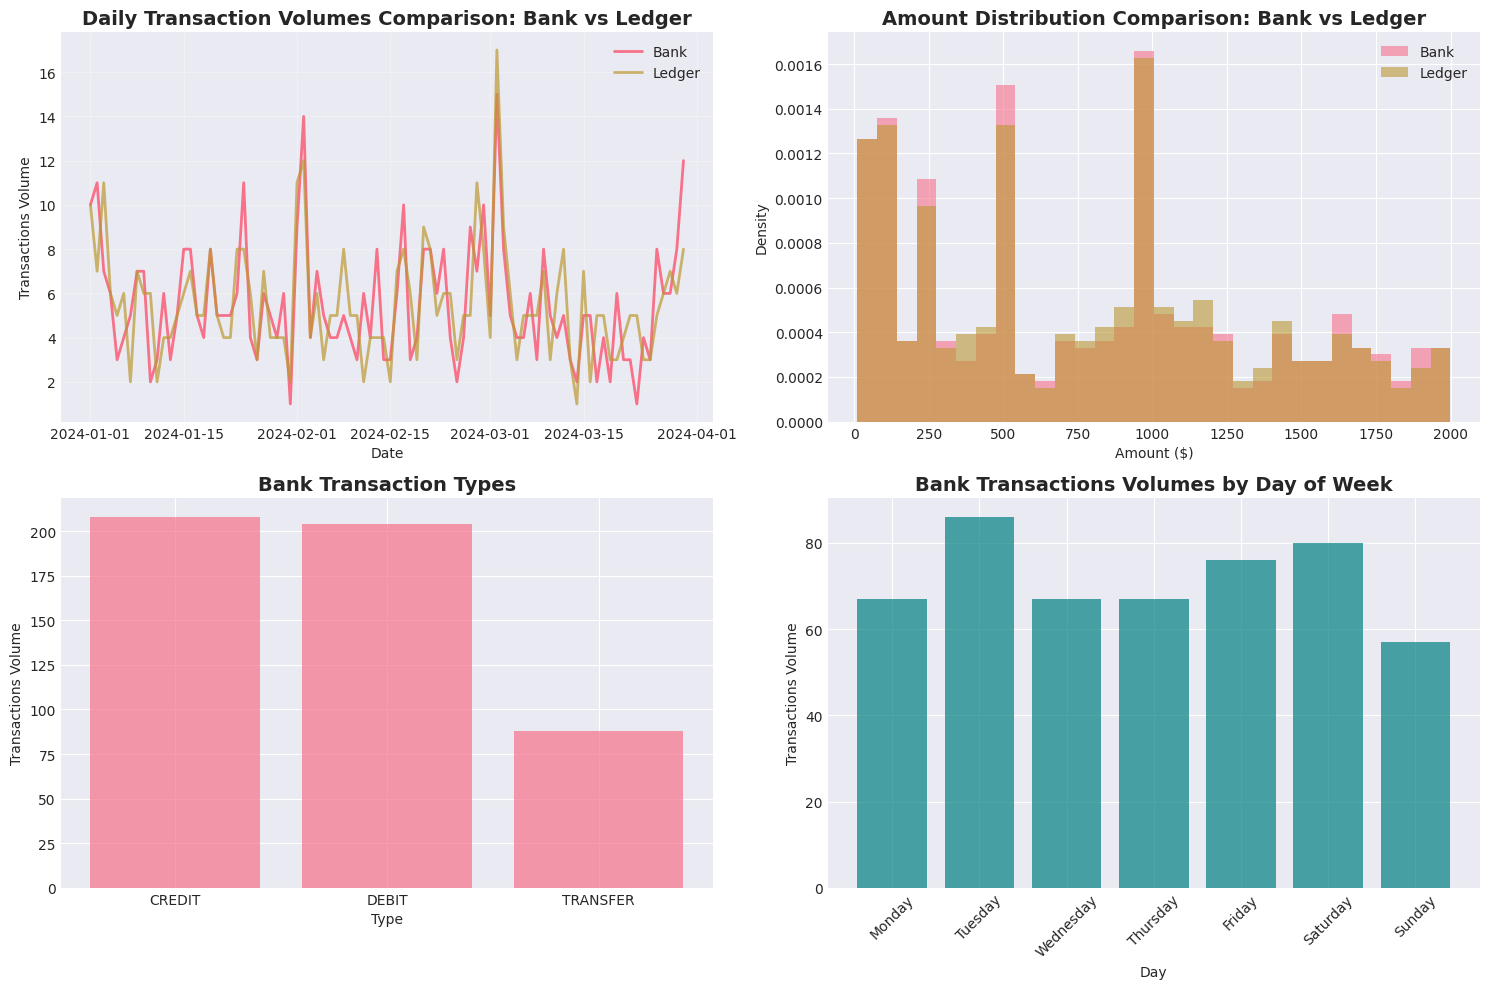

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

bank_df['date'] = pd.to_datetime(bank_df['date'])
ledger_df['date'] = pd.to_datetime(ledger_df['date'])

# Plot 1: Daily transaction counts
bank_daily = bank_df.groupby(bank_df['date'].dt.date).size()
ledger_daily = ledger_df.groupby(ledger_df['date'].dt.date).size()

axes[0, 0].plot(bank_daily.index, bank_daily.values, label='Bank', linewidth=2)
axes[0, 0].plot(ledger_daily.index, ledger_daily.values, label='Ledger', linewidth=2, alpha=0.7)
axes[0, 0].set_title('Daily Transaction Volumes Comparison: Bank vs Ledger', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Transactions Volume')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Transaction amount distribution
axes[0, 1].hist(bank_df['amount'].abs(), bins=30, alpha=0.6, label='Bank', density=True)
axes[0, 1].hist(ledger_df['amount'].abs(), bins=30, alpha=0.6, label='Ledger', density=True)
axes[0, 1].set_title('Amount Distribution Comparison: Bank vs Ledger', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Amount ($)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# Plot 3: Transaction types
if 'transaction_type' in bank_df.columns:
    bank_types = bank_df['transaction_type'].value_counts()
    axes[1, 0].bar(bank_types.index, bank_types.values, alpha=0.7)
    axes[1, 0].set_title('Bank Transaction Types', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Type')
    axes[1, 0].set_ylabel('Transactions Volume')

# Plot 4: Day of week pattern
bank_df['day_of_week'] = bank_df['date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = bank_df['day_of_week'].value_counts().reindex(day_order)
axes[1, 1].bar(day_counts.index, day_counts.values, alpha=0.7, color='teal')
axes[1, 1].set_title('Bank Transactions Volumes by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day')
axes[1, 1].set_ylabel('Transactions Volume')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**EDA insights:**

1. We have different transaction volumes in bank vs ledger data, which implies presennce of discrepancies
      - This could be due to: 
        - timing differences (some bank transactions of day x reflecting on day y in the ledger)
        - different transaction volumes for the same days

There fore in the next sections shall be exploring data for patterns as I set the different matching logic rules